Convolutional Neural Networks is class of deep learning models, that is primarily used for analyzing visual imagery. A convolution layer transforms an input volume into an output volume of different size.
Let's introduce some basic concepts in CNNs - that will together later make CNNs a really powerful tool.

### Padding
Padding provides control onto the size of volumes in the network. For a deeper CNN, it plays an important role by discouraging shrinking of the volumes. It also plays a role by keeping more of information at the border of an image.
Note that after applying padding, height and width of image change by twice the padding size!

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def pad( input_volume, pad_size, pad ):
    return np.pad( input_volume, ((pad_size,pad_size),(pad_size,pad_size)), 'constant', constant_values=pad )

np.random.seed(1) #to keep behaviour consistent
x = np.random.randn(4,3)
print ("x.shape =", x.shape)
plt.imshow(x)

fig, axarr = plt.subplots(1,3)

indexi = 0;
for pad_size in [1,2,3]:
    pad_value = np.random.randint(4)
    x_pad = pad(x, pad_size, pad_value )
    print ("shape after applying pad of size {} is {}".format(pad_size, x_pad.shape ))
    axarr[indexi].set_title('with size {} and pad {}'.format(pad_size, pad_value))
    axarr[indexi].imshow(x_pad)
    indexi = indexi + 1
fig.tight_layout()

x.shape = (4, 3)
shape after applying pad of size 1 is (6, 5)
shape after applying pad of size 2 is (8, 7)
shape after applying pad of size 3 is (10, 9)


### Strides

When applying a filter on an input volume, we need not iterate by step of 1 pixel as we slide over the input volume - rather we can have a step size i.e stride. In practice, stride lengths of S >= 3 are rare.
We can see below that as we increase stride size, total number of iterations for whole volume decrease, and final output size decrease as well. Note that volume of output will be floor[(h-f)/stride + 1] * floor[(w-f)/stride + 1] * #channels

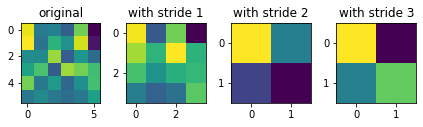

In [2]:
#Let's say we have 3x3 filter we are applying on a 6x6x1 volume
def stride( x, filtr, stride_length):  #here we show on 2D matrix only
    (h,w) = x.shape
    (f,f) = filtr.shape
    #output volume will be : floor( [h-f]/s ) + 1
    outputH = (int)( (h-f)/stride_length + 1)
    outputW = (int)( (w-f)/stride_length + 1)
    output = np.zeros((outputH, outputW))
    for i in range(outputH):
        for j in range(outputW):
            x_part = x[(stride_length*i):(stride_length*i+f), (stride_length*j):(stride_length*j+f)]
            output[i][j] = np.sum( np.multiply(x_part,f) ) #no bias
    return output

np.random.seed(1)
x = np.random.randn(6,6)
filtr = np.array([[1,0,-1],[1,0,-1],[1,0,-1]])

fig, axarr = plt.subplots(1,4)
axarr[0].set_title('original')
axarr[0].imshow(x)
indexi = 1;
for stride_length in [1,2,3]:
    output = stride(x, filtr, stride_length)
    axarr[indexi].set_title('with stride {}'.format(stride_length))
    axarr[indexi].imshow(output)
    indexi = indexi + 1

fig.tight_layout()

### Pooling

The pooling layer plays a rule in reducing the height and width of the input, thus reducing total computation cost to iterate as we go deeper in the network. It also helps make feature detectors more invariant to its position in the input. Two kinds of pooling we will see now as 'MAX' and 'AVG' - we slide a fxf size filter and compute either max/avg of current window.

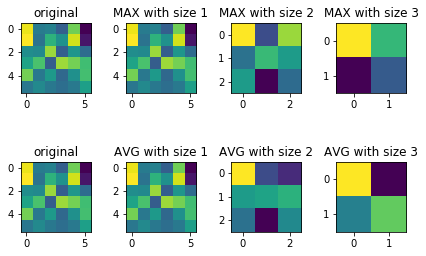

In [3]:
def pool( x, f_size, stride_length, typ='MAX' ):
    (h,w) = x.shape
    outputH = (int)( (h-f_size)/stride_length + 1)
    outputW = (int)( (w-f_size)/stride_length + 1)
    output = np.zeros((outputH,outputW))
    for i in range(outputH):
        for j in range(outputW):
            x_part = x[(stride_length*i):(stride_length*i+f_size), (stride_length*j):(stride_length*j+f_size)]
            if typ=='MAX':
                output[i][j] = np.max( x_part )
            elif typ=='AVG':
                output[i][j] = np.mean( x_part )
    return output

np.random.seed(1)
x = np.random.randn(6,6)

fig, axarr = plt.subplots(2,4)
for i in range(2):
    axarr[i][0].set_title('original')
    axarr[i][0].imshow(x)
    indexi = 1;
    for f_size in [1,2,3]:
        if i==0:
            output = pool(x, f_size, f_size, typ='MAX')
            axarr[i][indexi].set_title('MAX with size {}'.format(f_size))
        else:
            output = pool(x, f_size, f_size, typ='AVG')
            axarr[i][indexi].set_title('AVG with size {}'.format(f_size))
        axarr[i][indexi].imshow(output)
        indexi = indexi + 1
fig.tight_layout()

### CNN forward pass
Let's see how forward pass in a CNN works - typically as we work on projects, we won't code this thing up, rather use awesome deep learning frameworks like tensorflow, etc to make things easy for us.

In [4]:
#say, we have m training examples in our current batch of optimization step
def forward_pass(inputI, W, b, stride, pad_size):
    (m, inputH, inputW, inputC ) = inputI.shape
    (f, f, inputC, outputC) = W.shape #we have n_C filters each of volume f*f*( #channels in previous activation )

    outputH = int( (inputH + 2*pad_size - f)/stride + 1 )
    outputW = int( (inputW + 2*pad_size - f)/stride + 1 )
    output = np.zeros(shape=(m, outputH, outputW, outputC))
    
    input_pad = np.pad( inputI, ((0,0),(pad_size,pad_size),(pad_size,pad_size),(0,0)), 'constant', constant_values=0)
    for i in range(m):
        input_pad_i = input_pad[i]
        for h in range(outputH):
            for w in range(outputW):
                for c in range(outputC):
                    input_part = input_pad_i[(h*stride):(h*stride+f),(w*stride):(w*stride+f),:]
                    output[i, h, w, c] = np.sum( np.multiply( input_part, W[...,c] ) ) + (float)(b[...,c])

    assert(output.shape == (m, outputH, outputW, outputC))
    return output

In [5]:
np.random.seed(1)
A_prev = np.random.randn(10,4,4,3)
W = np.random.randn(2,2,3,8)
b = np.random.randn(1,1,1,8)
output = forward_pass(A_prev, W, b, 2,2)
print("Output size is {}".format(output.shape))
print("Output[1,1,1,:] is {}".format(output[1][1][1][:])); #all channels of first example, first row and first column

Output size is (10, 4, 4, 8)
Output[1,1,1,:] is [ 0.08367282 -2.0808981  -4.16119517  3.38827198  0.54974167 -1.78610875
 -4.71325433 -0.89005663]
